# Unit selection based on counterfactual logic

Causal ML contains an experimental version of the counterfactual unit selection method proposed by [Li and Pearl (2019)](https://ftp.cs.ucla.edu/pub/stat_ser/r488.pdf). The method has not been extensively tested or optimised so the user should proceed with caution. This notebook demonstrates the basic use of the counterfactual unit selector.

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

from causalml.dataset import make_uplift_classification
from causalml.optimize import CounterfactualUnitSelector
from causalml.optimize import get_treatment_costs
from causalml.optimize import get_actual_value

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Failed to import duecredit due to No module named 'duecredit'


## Generate data
We first generate some synthetic data using the built-in function.

In [2]:
df, X_names = make_uplift_classification(n_samples=5000,
                                         treatment_name=['control', 'treatment'])

In [3]:
# Lump all treatments together for this demo
df['treatment_numeric'] = df['treatment_group_key'].replace({'control': 0, 'treatment': 1})

In [4]:
df['treatment_group_key'].value_counts()

treatment    5000
control      5000
Name: treatment_group_key, dtype: int64

## Specify payoffs
In the context of a simple two-armed experiment, the counterfactual unit selection approach considers the following four segments of individuals:

* Never-takers: those who will not convert whether or not they are in the treatment
* Always-takers: those who will convert whether or not they are in the treatment
* Compliers: those who will convert if they are in the treatment and will not convert if they are in the control
* Defiers: those who will convert if they are in the control and will not convert if they are in the treatment

If we assume that the payoff from conversion is \$20 and the conversion cost of a treatment is \$2.5, then we can calculate the payoffs for targeting each type of individual as follows. For nevertakers, the payoff is always \$0 because they will not convert or use a promotion. For alwaystakers, the payoff is -\$2.5 because they would convert anyway but now we additionally give them a treatment worth \$2.5. For compliers, the payoff is the benefit from conversion minus the cost of the treatment, and for defiers the payoff is -\$20 because they would convert if we didn't treat them.

In [5]:
nevertaker_payoff = 0
alwaystaker_payoff = -2.5
complier_payoff = 17.5
defier_payoff = -20

## Run counterfactual unit selector

In this section we run the CounterfactualUnitSelector model and compare its performance against random assignment and a scheme in which all units are assigned to the treatment that has the best conversion in the training set. We measure the performance by looking at the average actual value payoff from those units in the testing set who happen to be in the treatment group recommended by each approach.

In [6]:
# Specify the same costs as above but in a different form
tc_dict = {'control': 0, 'treatment': 2.5}
ic_dict = {'control': 0, 'treatment': 0}
conversion_value = np.full(df.shape[0], 20)

# Use the above information to get the cost of each treatment
cc_array, ic_array, conditions = get_treatment_costs(
    treatment=df['treatment_group_key'], control_name='control',
    cc_dict=tc_dict, ic_dict=ic_dict)
    
# Get the actual value of having a unit in their actual treatment
actual_value = get_actual_value(treatment=df['treatment_group_key'],
                                observed_outcome=df['conversion'],
                                conversion_value=conversion_value,
                                conditions=conditions,
                                conversion_cost=cc_array,
                                impression_cost=ic_array)

In [7]:
df_train, df_test = train_test_split(df)
train_idx = df_train.index
test_idx = df_test.index

In [8]:
# Get the outcome if treatments were allocated randomly
random_allocation_value = actual_value.loc[test_idx].mean()

# Get the actual value of those individuals who are in the best
# treatment group
best_ate = df_train.groupby(
    'treatment_group_key')['conversion'].mean().idxmax()
actual_is_best_ate = df_test['treatment_group_key'] == best_ate
best_ate_value = actual_value.loc[test_idx][actual_is_best_ate].mean()

In [9]:
cus = CounterfactualUnitSelector(learner=LogisticRegressionCV(),
                                 nevertaker_payoff=nevertaker_payoff,
                                 alwaystaker_payoff=alwaystaker_payoff,
                                 complier_payoff=complier_payoff,
                                 defier_payoff=defier_payoff)

cus.fit(data=df_train.drop('treatment_group_key', 1),
        treatment='treatment_numeric',
        outcome='conversion')

cus_pred = cus.predict(data=df_test.drop('treatment_group_key', 1),
                       treatment='treatment_numeric',
                       outcome='conversion')

best_cus = np.where(cus_pred > 0, 1, 0)
actual_is_cus = df_test['treatment_numeric'] == best_cus.ravel()
cus_value = actual_value.loc[test_idx][actual_is_cus].mean()

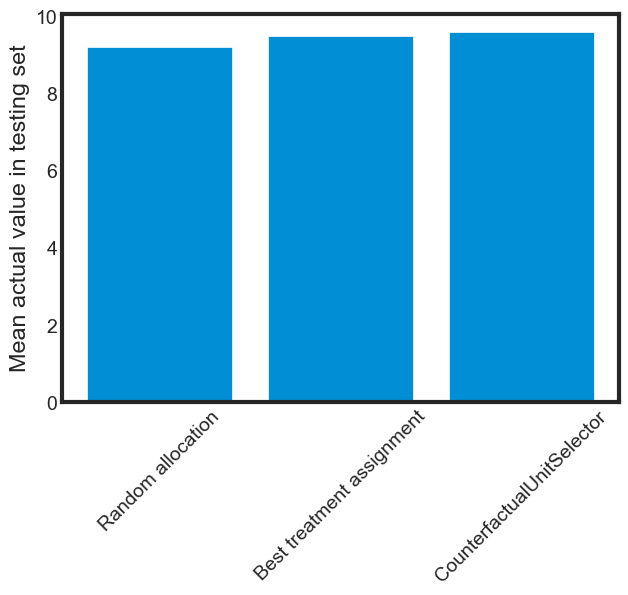

In [10]:
labels = ['Random allocation', 'Best treatment assignment', 'CounterfactualUnitSelector']
values = [random_allocation_value, best_ate_value, cus_value]

plt.bar(labels, values)
plt.ylabel('Mean actual value in testing set')
plt.xticks(rotation=45)
plt.show()